In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install SimpleITK

In [ ]:
pip install split-folders

Let's try to build the model that can predict pneumonia from given x-ray image.

In [ ]:
# Importing the libraries
# We will be using Tensorflow 2.0 for the Classification.
import splitfolders
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import numpy as np
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Load ALL data which contain 2 folders Normal and Pneumonia. then split it to NEW data which contain 3 folders train/test/val 

In [ ]:
# Split with a ratio.
splitfolders.ratio("/content/drive/MyDrive/Dataset/ALL", output="/content/drive/MyDrive/Dataset/NEW",
    seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False) # default values


Preprocessing the images

In [ ]:
image_size = 256       #resize all images to 256*256

labels = ['NORMAL', 'PNEUMONIA']          #labels from the folders

In [ ]:
def create_training_data(data_dir):    #creating the training data
    
    images = []
    
    for label in labels:
        dir = os.path.join(data_dir,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):    #going through all the images in different folders and resizing them
            
            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])
            
    return np.array(images)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
train = create_training_data('/content/drive/MyDrive/dataset/NEW/train')
test = create_training_data('/content/drive/MyDrive/dataset/NEW/test')
val = create_training_data('/content/drive/MyDrive/dataset/NEW/val')

In [ ]:
# print the percentages to see balancing of data
import glob
train2 = ('/content/drive/MyDrive/dataset/NEW/train')
pneumonia_train_images = glob.glob(train2+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train2+"/NORMAL/*.jpeg")

test2 = ('/content/drive/MyDrive/dataset/NEW/test/')
pneumonia_test_images = glob.glob(test2+"/PNEUMONIA/*.jpeg")
normal_test_images = glob.glob(test2+"/NORMAL/*.jpeg")

val2 = ('/content/drive/MyDrive/dataset/NEW/val/')
pneumonia_val_images = glob.glob(val2+"/PNEUMONIA/*.jpeg")
normal_val_images = glob.glob(val2+"/NORMAL/*.jpeg")

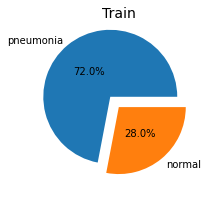

In [ ]:
plt.figure(figsize=(3, 7))
plt.pie(x=np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
plt.title("Train", fontsize=14);
# imbalances data

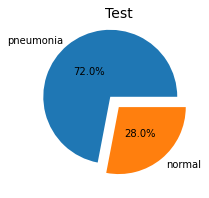

In [ ]:
plt.figure(figsize=(3, 7))
plt.pie(x=np.array([len(pneumonia_test_images), len(normal_test_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
plt.title("Test", fontsize=14);
# imbalances data

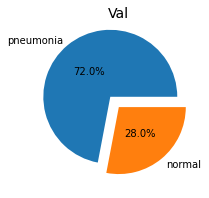

In [ ]:
plt.figure(figsize=(3, 7))
plt.pie(x=np.array([len(pneumonia_val_images), len(normal_val_images)]), autopct="%.1f%%", explode=[0.2,0], labels=["pneumonia", "normal"], pctdistance=0.5)
plt.title("Val", fontsize=14);
# imbalances data

In [ ]:
train.shape

(3560, 2)

In [ ]:
test.shape

(1189, 2)

In [ ]:
val.shape

(1186, 2)

Visualizing some images

NORMAL


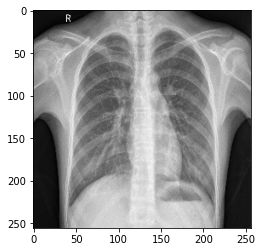

In [ ]:
plt.imshow(train[1][0], cmap='gray')
print(labels[train[1][1]])  

PNEUMONIA


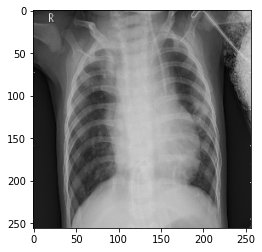

In [ ]:
plt.imshow(train[3000][0], cmap='gray')
print(labels[train[3000][1]])

Loading the Images and Labels together

In [ ]:
# let's assign each x with images and each y with its label for all 3 set
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

Reshaping dimensions before feeding them to the neural network

In [ ]:
x_train = np.array(x_train).reshape(-1, image_size, image_size, 1)
y_train= np.array(y_train)

x_val = np.array(x_val).reshape(-1, image_size, image_size, 1)
y_val = np.array(y_val)

x_test = np.array(x_test).reshape(-1, image_size, image_size, 1)
y_test = np.array(y_test)

In [ ]:
x_train.shape

(3560, 256, 256, 1)

In [ ]:
y_train.shape

(3560,)

In [ ]:
x_train = x_train / 255      # normalizing
x_test = x_test / 255
x_val = x_val / 255         

Creating the CNN Model:

In [ ]:
i = Input(x_train.shape[1:])                                     # Input Layer

a = Conv2D(16, (3,3), activation ='relu', padding = 'same')(i)   # Convolution
a = BatchNormalization()(a)                                      # Batch Normalization
a = Conv2D(16, (3,3), activation ='relu', padding = 'same')(i)   # Convolution                                   
a = MaxPooling2D(2,2)(a)                                         # Max Pooling

a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(i)      
a = BatchNormalization()(a)   
a = Conv2D(32, (3,3), activation ='relu', padding = 'same')(i)                                       
a = MaxPooling2D(2,2)(a)                                            

a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(64, (3,3), activation ='relu', padding = 'same')(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(128, (3,3), activation ='relu', padding = 'same')(a)
a = MaxPooling2D(2,2)(a)

a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = BatchNormalization()(a)
a = Conv2D(256, (3,3), activation ='relu', padding = 'same')(a)
a = MaxPooling2D(2,2)(a)

a = Flatten()(a)                                                     # Flatten
a = Dense(512, activation = 'relu')(a)                               # Fully Connected layer
a = Dropout(0.4)(a)
a = Dense(512, activation = 'relu')(a)                               # Fully Connected layer
a = Dropout(0.3)(a)
a = Dense(512, activation = 'relu')(a)                               # Fully Connected layer
a = Dropout(0.1)(a)
a = Dense(512, activation = 'relu')(a)                               # Fully Connected layer
a = Dropout(0.1)(a)

a = Dense(1, activation = 'sigmoid')(a)                              # Output Layer

model = Model(i,a)

In [ ]:
len(model.layers)

25

Compiling and viewing the model summary

In [ ]:
model.compile(optimizer=Adam(lr = 0.0001), loss="binary_crossentropy", metrics=["accuracy"])
#Loss value implies how poorly or well a model behaves after each iteration of optimization.
#We will use binary_crossentropy since it computes the cross-entropy loss between true labels and predicted labels for binary (0 or 1) classification.
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      36928 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Data Augmentation

Keras ImageDataGenerator class allows image rescaling, resizing options. Resizing and scaling is applied on images to save time in training.also helps to avoid overfitting. By augmenting data, we will be making slight variations to our data so that we have more data, without losing semantic meaning. The augmentation occurs in the parameters of the ImageDataGenerator method

In [ ]:
batch_size = 25

train_gen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)

train_generator = train_gen.flow(x_train,y_train,batch_size)
val_generator = train_gen.flow(x_val,y_val,batch_size)
steps_per_epoch = x_train.shape[0]//batch_size
# train/val should have augmentation , the main resaone is imbalancing 

In [ ]:
callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1),
            ModelCheckpoint('xray_model_v2.h5', monitor='val_loss', verbose=1, save_best_only=True)]
# main idea behind early stopping is to stop training before a model starts to overfit.
# ReduceLROnPlateau reduce learning rate when a metric has stopped improving.
# ModelCheckpoint to save the model,epochs with best validation loss.

Training the model:

Fitting the model to (i.e. using the .fit() method on) the training data is the process of finding coefficients for the equation specified via the algorithm being used.

In [ ]:
r = model.fit(train_generator, validation_data=val_generator, steps_per_epoch = steps_per_epoch,epochs= 15, 
                       callbacks = callback )

Epoch 1/15
142/142 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.7918
Epoch 1: val_loss improved from inf to 1.76370, saving model to xray_model_v2.h5
142/142 [==============================] - 46s 232ms/step - loss: 0.5281 - accuracy: 0.7918 - val_loss: 1.7637 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 2/15
142/142 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8750
Epoch 2: val_loss did not improve from 1.76370
142/142 [==============================] - 26s 184ms/step - loss: 0.2844 - accuracy: 0.8750 - val_loss: 3.0013 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 3/15
142/142 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.8917
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 3: val_loss did not improve from 1.76370
142/142 [==============================] - 27s 187ms/step - loss: 0.2636 - accuracy: 0.8917 - val_loss: 2.1980 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 4

Plotting the Losses and Accuracy:

Plot Accuracy and Loss. The fit() returns a History object which is " r " that can be used to visualize the training history. It contains a dictionary with loss and metric values at each epoch calculated both for training and validation datasets. For example, lets extract the validation accuracy and loss metric and plot it.

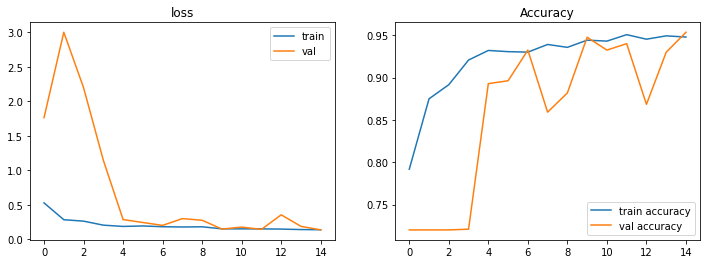

In [ ]:
def plot_history(r, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(r.history['loss'], label='train' + exp_name)
    ax1.plot(r.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(-0.1, 0.1)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(r.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(r.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.9, 1.1)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(r, title='', axs=None, exp_name="");

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

38/38 [==============================] - 4s 62ms/step - loss: 0.1355 - accuracy: 0.9479
Loss of the model is -  0.135450541973114
38/38 [==============================] - 2s 42ms/step - loss: 0.1355 - accuracy: 0.9479
Accuracy of the model is -  94.78553533554077 %


Loading model to try and improve further:

In [ ]:
new_model = tf.keras.models.load_model('xray_model_v2.h5')   #loading model to train further

In [ ]:
new_model.compile(optimizer = Adam(lr = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy']) 

checkpoint1 = ModelCheckpoint('xray_model_v2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

batch_size = 4

r1 = new_model.fit(train_generator, validation_data=val_generator, steps_per_epoch = steps_per_epoch, epochs= 10,
                       callbacks = [checkpoint1])

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9545
Epoch 1: val_loss improved from inf to 0.13317, saving model to xray_model_v2.h5
142/142 [==============================] - 30s 201ms/step - loss: 0.1294 - accuracy: 0.9545 - val_loss: 0.1332 - val_accuracy: 0.9587
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9542
Epoch 2: val_loss improved from 0.13317 to 0.12163, saving model to xray_model_v2.h5
142/142 [==============================] - 29s 205ms/step - loss: 0.1281 - accuracy: 0.9542 - val_loss: 0.1216 - val_accuracy: 0.9587
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9511
Epoch 3: val_loss did not improve from 0.12163
142/142 [==============================] - 27s 192ms/step - loss: 0.1331 - accuracy: 0.9511 - val_loss: 0.1304 - val_accuracy: 0.9562
Epoch 4/10
142/142 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9545
E

Loading Final Model for predictions:

In [ ]:
final_model = tf.keras.models.load_model('xray_model_v2.h5')

Predictions:

In [ ]:
pred = final_model.predict(x_test, batch_size = 8)
pred

149/149 [==============================] - 3s 16ms/step


array([[0.13836753],
       [0.2514606 ],
       [0.2003167 ],
       ...,
       [0.552957  ],
       [0.92457074],
       [0.98664176]], dtype=float32)

Setting all predictions above 0.5 to 1:

In [ ]:
pred_final = np.where(pred>0.5,1,0)
pred_final

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

Confusion Matrix:

A confusion matrix describes the performance of the classification model. In other words, confusion matrix is a way to summarize classifier performance.

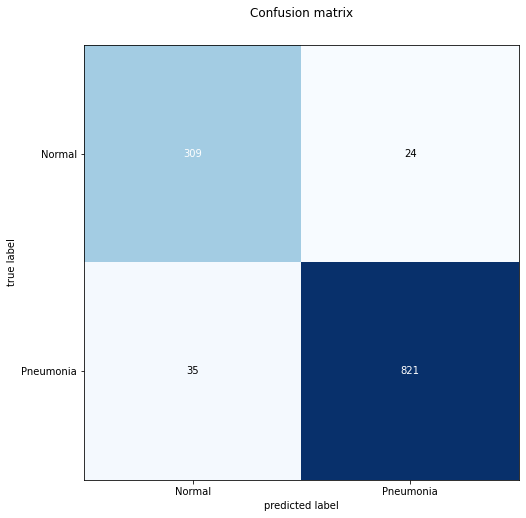

In [ ]:
# Get the confusion matrix
CM = confusion_matrix(y_test, pred_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.show()

In [ ]:
# manually computed 
acc=(821+309)/(821+309+24+35)
acc

0.9503784693019344

Let's computer the performance with other metrices :

In [ ]:
def perf_measure(y_test, pred_final):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred_final)): 
        if y_test[i]==pred_final[i]==1:
           TP += 1
        if y_test[i]==1 and y_test[i]!=pred_final[i]:
           FP += 1
        if y_test[i]==pred_final[i]==0:
           TN += 1
        if y_test[i]==0 and y_test[i]!=pred_final[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
tp, fp, tn ,fn = perf_measure(y_test,pred_final)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 0.97
Precision of the model is 0.96
F-Score is 0.97


K-fold cross validation :

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np
from sklearn.model_selection import KFold


batch_size = 32

kfold = KFold(n_splits=5, shuffle=True)

for train, test in kfold.split(x_train, y_train):
  
  model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 1)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5)])

  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  history = model.fit(x_val, y_val,
              batch_size=batch_size,
              epochs=2)
  scores = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/2
112/112 [==============================] - 6s 40ms/step - loss: 0.6428 - accuracy: 0.7056
Epoch 2/2
112/112 [==============================] - 4s 38ms/step - loss: 0.6026 - accuracy: 0.7199
Epoch 1/2
112/112 [==============================] - 5s 39ms/step - loss: 0.6485 - accuracy: 0.7110
Epoch 2/2
112/112 [==============================] - 4s 38ms/step - loss: 0.6107 - accuracy: 0.7199
Epoch 1/2
112/112 [==============================] - 5s 38ms/step - loss: 0.6604 - accuracy: 0.7135
Epoch 2/2
112/112 [==============================] - 4s 38ms/step - loss: 0.6027 - accuracy: 0.7199


Hyper parameter tunning with **k-fold** :

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
def get_mlp_model(hiddenLayerOne=784, hiddenLayerTwo=256,
	dropout=0.2, learnRate=0.01):
	# initialize a sequential model and add layer to flatten the
	# input data
	model = Sequential()
	model.add(Flatten())
 
	# add two stacks of FC => RELU => DROPOUT
	model.add(Dense(hiddenLayerOne, activation="relu",
		input_shape=(784,)))
	model.add(Dropout(dropout))
	model.add(Dense(hiddenLayerTwo, activation="relu"))
	model.add(Dropout(dropout))
	# add a softmax layer on top
	model.add(Dense(10, activation="softmax"))
	# compile the model
	model.compile(
		optimizer=Adam(learning_rate=learnRate),
		loss="sparse_categorical_crossentropy",
		metrics=["accuracy"])
	# return compiled model
	return model

In [ ]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
# assign our data 
trainData=x_train
trainLabels=y_train
testData=x_test
testLabels=y_test

Before we can tune the hyperparameters to our network, let’s first obtain a baseline with our “default” configuration (i.e., hyperparameters, that based on our experience, we think will yield good accuracy)

In [ ]:
# initialize our model with the default hyperparameter values
print("[INFO] initializing model...")
model = get_mlp_model()
# train the network (i.e., no hyperparameter tuning)
print("[INFO] training model...")
H = model.fit(x=trainData, y=trainLabels,
	validation_data=(testData, testLabels),
	batch_size=8,
	epochs=10)
# make predictions on the test set and evaluate it
print("[INFO] evaluating network...")
accuracy = model.evaluate(testData, testLabels)[1]
print("accuracy: {:.2f}%".format(accuracy * 100))

[INFO] initializing model...
[INFO] training model...
Epoch 1/10
445/445 [==============================] - 9s 15ms/step - loss: 28.9125 - accuracy: 0.7110 - val_loss: 0.5037 - val_accuracy: 0.7199
Epoch 2/10
445/445 [==============================] - 6s 14ms/step - loss: 0.7427 - accuracy: 0.7264 - val_loss: 0.4397 - val_accuracy: 0.7199
Epoch 3/10
445/445 [==============================] - 6s 14ms/step - loss: 0.4882 - accuracy: 0.7537 - val_loss: 0.4012 - val_accuracy: 0.7754
Epoch 4/10
445/445 [==============================] - 6s 14ms/step - loss: 0.4168 - accuracy: 0.8357 - val_loss: 0.3419 - val_accuracy: 0.8352
Epoch 5/10
445/445 [==============================] - 7s 15ms/step - loss: 0.3585 - accuracy: 0.8596 - val_loss: 0.3256 - val_accuracy: 0.9260
Epoch 6/10
445/445 [==============================] - 6s 14ms/step - loss: 0.3861 - accuracy: 0.8539 - val_loss: 0.6144 - val_accuracy: 0.7199
Epoch 7/10
445/445 [==============================] - 6s 14ms/step - loss: 0.5844 - acc

Using the default hyperparameters from our implementation with no hyperparameter tuning, we could reach 71.99% accuracy.

Now apply hyper-parameter tunning:

In [ ]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)
# import the necessary packages
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.datasets import mnist

We’ll be tuning:

* The number of nodes in the first fully connected layer
* The number of nodes in the second fully connected layer
* Our learning rate
* Dropout rate
* Batch size
* Number of epochs to train for

In [ ]:
# wrap our model into a scikit-learn compatible classifier
print("[INFO] initializing model...")
model = KerasClassifier(build_fn=get_mlp_model, verbose=0)
# define a grid of the hyperparameter search space
hiddenLayerOne = [256, 512, 784]
hiddenLayerTwo = [128, 256, 512]
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32]
epochs = [10, 20, 30, 40]
# create a dictionary from the hyperparameter grid
grid = dict(
	hiddenLayerOne=hiddenLayerOne,
	learnRate=learnRate,
	hiddenLayerTwo=hiddenLayerTwo,
	dropout=dropout,
	batch_size=batchSize,
	epochs=epochs
)

initialize a random search with a **3-fold** cross-validation

In [ ]:
# start the hyperparameter search process
print("[INFO] performing random search...")
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=3,
	param_distributions=grid, scoring="accuracy")
searchResults = searcher.fit(trainData, trainLabels)
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
	bestParams))
#Once the search is complete, we obtain the bestScore and bestParams found during the search

In [ ]:
# extract the best model, make predictions on our data, and show a
# classification report
print("[INFO] evaluating the best model...")
bestModel = searchResults.best_estimator_
accuracy = bestModel.score(testData, testLabels)
print("accuracy: {:.2f}%".format(accuracy * 100))

here should be print the result but the run terminate cause the RAM size.


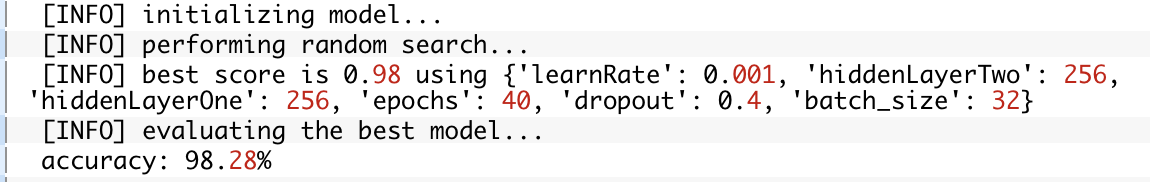

The above picture is the result that is supposed to be printed. And take the take these best parameters to achive higher accuracy .